# Stock price prediction using LSTM neural network and Tensorflow
What do we need here:
1. Load data
2. Scale data for machine learning model
3. Setup neural network
4. Compile model
5. Teach neural netowk and fit this
6. Use the model for prediction
7. Draw the results chart

In [1]:
# Requirements
!pip install yahoo_fin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 17.1 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1257 sha256=4f9105794d11be24ab3940e152b9bacdf312da0b541adbfbe4c02770502d5cc6
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6049 sha256=5f9c31f99f246091bfe1cef1775fb1664f0300f6a96373d06373d7d5d5e9240c
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built bs4 sgmllib3k
  Attempting uninstall: urllib3
    Found exis

In [2]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

In [3]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOGL
STOCK = 'AMZN'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [4]:
# LOAD DATA
# from yahoo_fin
# for 1104 bars with interval = 1d (one day)
bn58592n_df = yf.get_data(
    STOCK,
    start_date=date_3_years_back,
    end_date=date_now,
    interval='1d')

In [5]:
bn58592n_df.head()

,open,high,low,close,adjclose,volume,ticker
2020-11-16,154.660004,157.134995,153.634506,156.552994,156.552994,76174000,AMZN
2020-11-17,159.177002,159.462494,156.763000,156.783005,156.783005,68894000,AMZN
2020-11-18,156.699997,157.000000,155.255005,155.272995,155.272995,58336000,AMZN
2020-11-19,155.265503,156.250000,154.046005,155.850998,155.850998,60206000,AMZN
2020-11-20,155.850998,156.644501,154.902496,154.970001,154.970001,67488000,AMZN


In [6]:
!date

Thu Nov 23 03:36:29 AM UTC 2023


In [8]:
%connect_info

{
  "shell_port": 1,
  "iopub_port": 2,
  "stdin_port": 3,
  "control_port": 4,
  "hb_port": 5,
  "ip": "/root/.local/share/jupyter/runtime/kernel-a4096cb4-3d7c-42d8-84b4-5cb09f4fd9e4-ipc",
  "key": "",
  "transport": "ipc",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-a4096cb4-3d7c-42d8-84b4-5cb09f4fd9e4.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [10]:
# remove columns which our neural network will not use
bn58592n_df = bn58592n_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
bn58592n_df['date'] = bn58592n_df.index

In [11]:
bn58592n_df

,close,date
2020-11-16,156.552994,2020-11-16
2020-11-17,156.783005,2020-11-17
2020-11-18,155.272995,2020-11-18
2020-11-19,155.850998,2020-11-19
2020-11-20,154.970001,2020-11-20
...,...,...
2023-11-16,142.830002,2023-11-16
2023-11-17,145.179993,2023-11-17
2023-11-20,146.130005,2023-11-20
2023-11-21,143.899994,2023-11-21


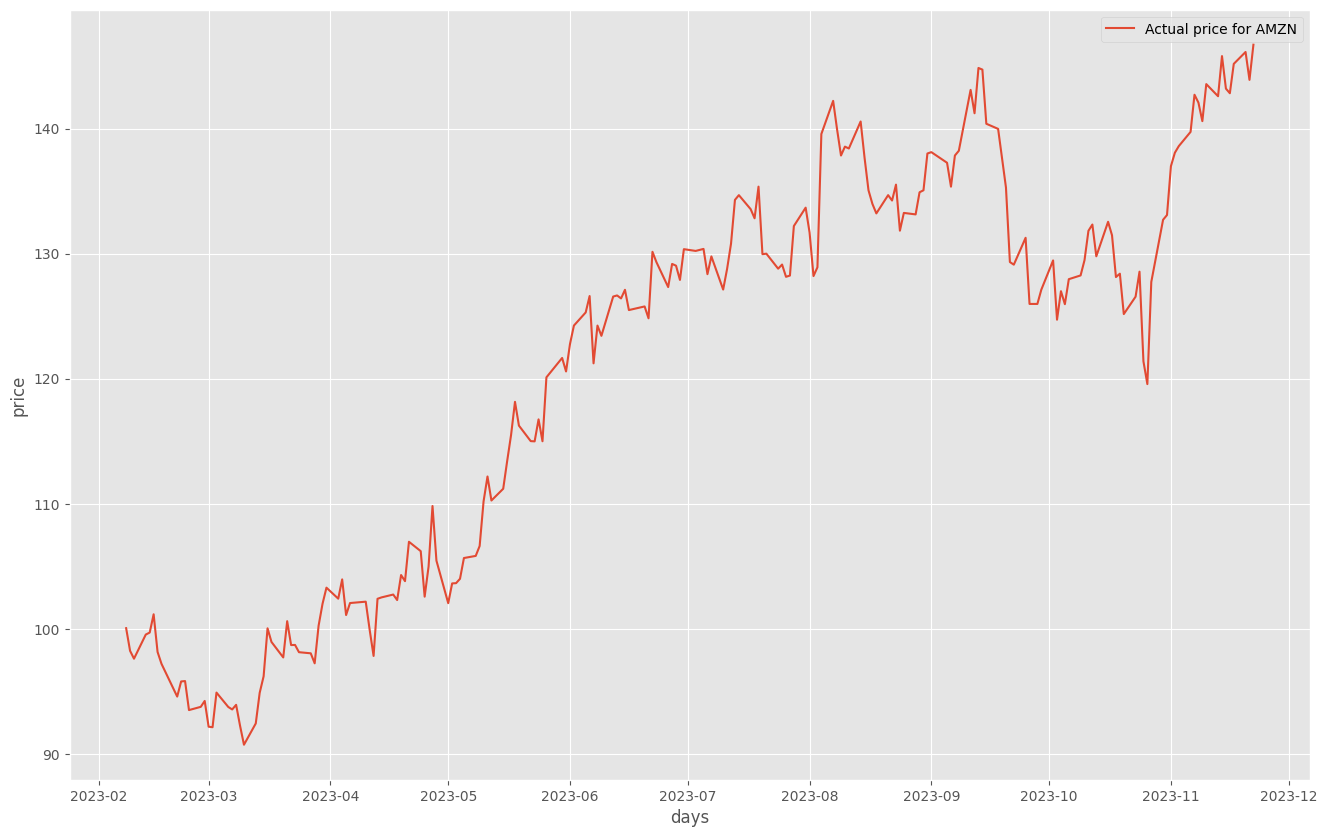

In [12]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(bn58592n_df['close'][-200:])
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [13]:
# Scale data for ML engine
scaler = MinMaxScaler()
bn58592n_df['scaled_close'] = scaler.fit_transform(np.expand_dims(bn58592n_df['close'].values, axis=1))

In [14]:
bn58592n_df

,close,date,scaled_close
2020-11-16,156.552994,2020-11-16,0.713438
2020-11-17,156.783005,2020-11-17,0.715634
2020-11-18,155.272995,2020-11-18,0.701219
2020-11-19,155.850998,2020-11-19,0.706736
2020-11-20,154.970001,2020-11-20,0.698326
...,...,...,...
2023-11-16,142.830002,2023-11-16,0.582432
2023-11-17,145.179993,2023-11-17,0.604866
2023-11-20,146.130005,2023-11-20,0.613935
2023-11-21,143.899994,2023-11-21,0.592646


In [15]:
def PrepareData(days):
  df = bn58592n_df.copy()
  df['future'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['scaled_close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [16]:
PrepareData(3) # 3 days

(                 close       date  scaled_close    future
 2020-11-16  156.552994 2020-11-16      0.713438  0.706736
 2020-11-17  156.783005 2020-11-17      0.715634  0.698326
 2020-11-18  155.272995 2020-11-18      0.701219  0.697844
 2020-11-19  155.850998 2020-11-19      0.706736  0.707233
 2020-11-20  154.970001 2020-11-20      0.698326  0.739218
 ...                ...        ...           ...       ...
 2023-11-13  142.589996 2023-11-13      0.580140  0.582432
 2023-11-14  145.800003 2023-11-14      0.610785  0.604866
 2023-11-15  143.199997 2023-11-15      0.585964  0.613935
 2023-11-16  142.830002 2023-11-16      0.582432  0.592646
 2023-11-17  145.179993 2023-11-17      0.604866  0.619472
 
 [757 rows x 4 columns],
 array([[0.561143  ],
        [0.58940053],
        [0.5801404 ],
        [0.6107847 ],
        [0.5859638 ],
        [0.5824316 ],
        [0.6048658 ],
        [0.6139351 ],
        [0.5926463 ],
        [0.6194721 ]], dtype=float32),
 array([[[0.713438093346493,

In [17]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [18]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80
95/95 [==============================] - 6s 8ms/step - loss: 0.0311
Epoch 2/80
95/95 [==============================] - 1s 9ms/step - loss: 0.0057
Epoch 3/80
95/95 [==============================] - 1s 9ms/step - loss: 0.0060
Epoch 4/80
95/95 [==============================] - 1s 8ms/step - loss: 0.0050
Epoch 5/80
95/95 [==============================] - 1s 9ms/step - loss: 0.0052
Epoch 6/80
95/95 [==============================] - 1s 10ms/step - loss: 0.0047
Epoch 7/80
95/95 [==============================] - 1s 13ms/step - loss: 0.0051
Epoch 8/80
95/95 [==============================] - 1s 12ms/step - loss: 0.0042
Epoch 9/80
95/95 [==============================] - 1s 12ms/step - loss: 0.0044
Epoch 10/80
95/95 [==============================] - 1s 11ms/step - loss: 0.0037
Epoch 11/80
95/95 [==============================] - 1s 8ms/step - loss: 0.0040
Epoch 12/80
95/95 [==============================] - 1s 8ms/step - loss: 0.0034
Epoch 13/80
95/95 [=========================

In [19]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'

  print(message)

AMZN prediction for upcoming 3 days (144.98$, 146.16$, 146.28$)


In [20]:
# Execute model for the whole history range
copy_bn58592n_df = bn58592n_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_bn58592n_df[f'predicted_close'] = y_predicted_transformed

24/24 [==============================] - 0s 5ms/step


In [21]:
copy_bn58592n_df

,close,date,scaled_close,predicted_close
2020-11-16,156.552994,2020-11-16,0.713438,158.401993
2020-11-17,156.783005,2020-11-17,0.715634,161.003998
2020-11-18,155.272995,2020-11-18,0.701219,160.176498
2020-11-19,155.850998,2020-11-19,0.706736,159.336502
2020-11-20,154.970001,2020-11-20,0.698326,158.128998
...,...,...,...,...
2023-11-16,142.830002,2023-11-16,0.582432,143.399551
2023-11-17,145.179993,2023-11-17,0.604866,144.901474
2023-11-20,146.130005,2023-11-20,0.613935,146.130005
2023-11-21,143.899994,2023-11-21,0.592646,143.899994


In [22]:
# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_bn58592n_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_bn58592n_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_bn58592n_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

<ipython-input-22-40a972d50202>:7: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  copy_bn58592n_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
<ipython-input-22-40a972d50202>:8: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  copy_bn58592n_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]


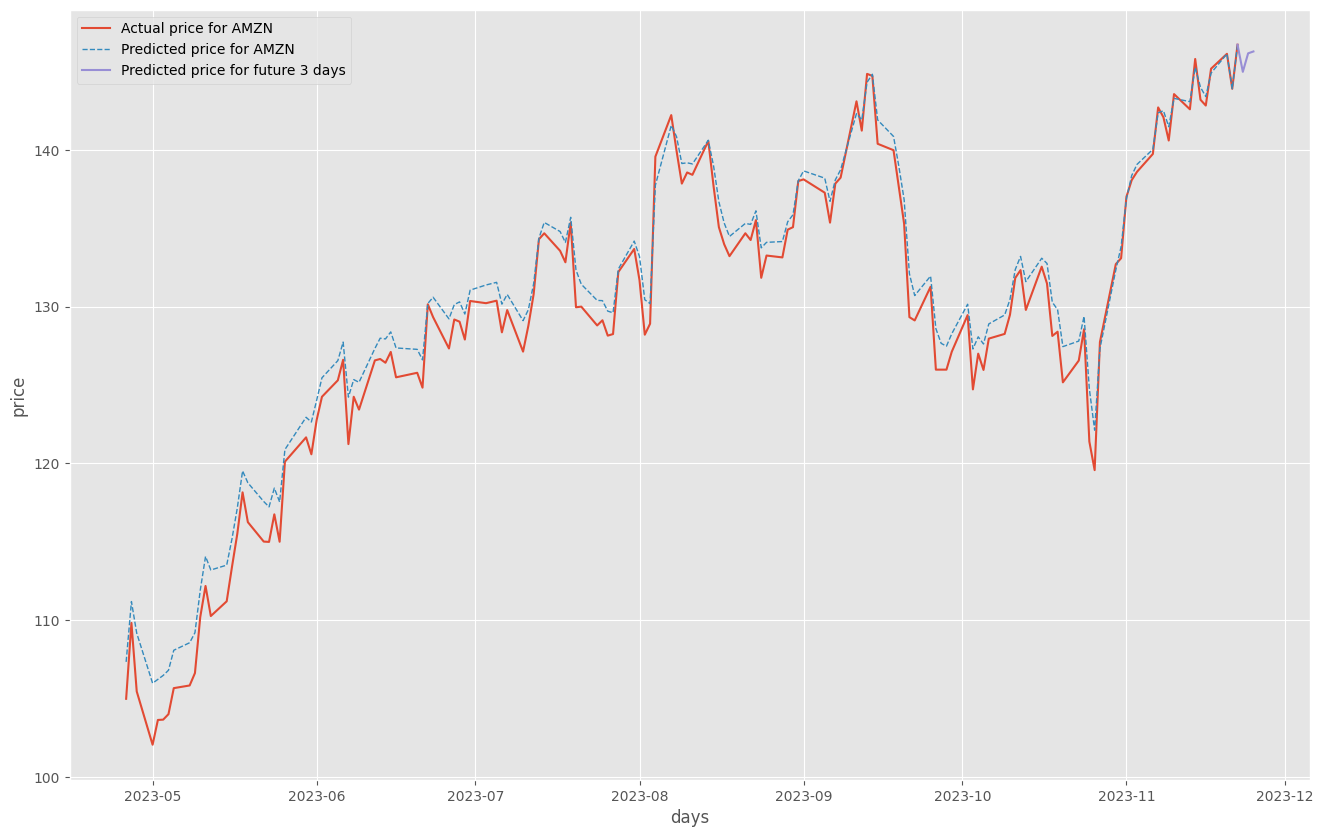

In [24]:
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_bn58592n_df['close'][-150:].head(147))
plt.plot(copy_bn58592n_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_bn58592n_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}',
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()